Distribuzione delle classi:
 label
2    0.528183
4    0.172251
3    0.135199
5    0.069373
6    0.056366
7    0.038628
Name: proportion, dtype: float64
Classi in y dopo label encoding: [0 1 2 3 4 5]


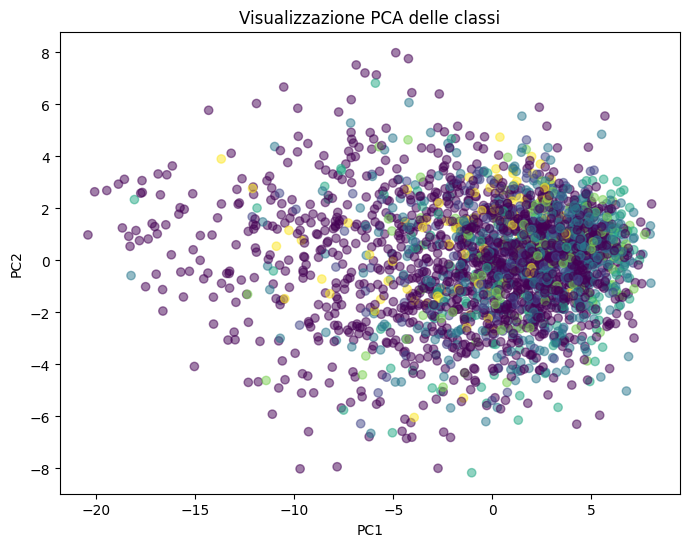


Training XGBoost pipeline


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import logging
import datetime
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Configurazione logging datetime
logging.basicConfig(
    filename=f"logs/model_evaluation_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Funzione per valutazione del modello
def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    log_msg = (
        f"\n--- Evaluation: {model_name} ---\n"
        f"Classification Report:\n{report}\n"
        f"Confusion Matrix:\n{matrix}\n"
        f"Balanced Accuracy: {bal_acc}\n"
        f"F1 Macro: {f1}\n"
        + "-"*80
    )

    logging.info(log_msg)
    print(log_msg)

def create_xgb_pipeline():
    pipeline = ImbPipeline([
        ('resampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('selector', RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20)), 
        ('classifier', XGBClassifier(use_label_encoder=True, eval_metric='mlogloss', random_state=42))
    ])

    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }

    return pipeline, param_dist

def create_rf_pipeline():
    pipeline = ImbPipeline([
        ('resampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('selector', RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20)), 
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])

    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }

    return pipeline, param_dist

def create_svm_pipeline():
    pipeline = ImbPipeline([
        ('resampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('selector', RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20)), 
        ('classifier', SVC(random_state=42, class_weight='balanced'))
    ])

    param_dist = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly']
    }

    return pipeline, param_dist

def create_lr_pipeline():
    pipeline = ImbPipeline([
        ('resampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('selector', RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20)), 
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
    ])

    param_dist = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }

    return pipeline, param_dist

def create_knn_pipeline():
    pipeline = ImbPipeline([
        ('resampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('selector', RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20)), 
        ('classifier', KNeighborsClassifier())
    ])

    param_dist = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }

    return pipeline, param_dist

def main():
    df = pd.read_csv("../roi_features_train.csv")
    X = df.drop(columns=["image_id", "score", "x1", "y1", "x2", "y2", "label"])
    y = df["label"]

    # Rimuove la classe 1
    X = X[y != 1]
    y = y[y != 1]
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    print("Distribuzione delle classi:\n", y.value_counts(normalize=True))

    le = LabelEncoder()
    y = le.fit_transform(y)
    print("Classi in y dopo label encoding:", np.unique(y))

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.title("Visualizzazione PCA delle classi")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    pipelines = [
        ("XGBoost", create_xgb_pipeline()),
        ("Random Forest", create_rf_pipeline()),
        ("SVM", create_svm_pipeline()),
        ("Logistic Regression", create_lr_pipeline()),
        ("KNN", create_knn_pipeline())
    ]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, (pipeline, param_dist) in pipelines:
        print(f"\n{'='*40}\nTraining {name} pipeline\n{'='*40}")

        search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=cv,
                                    scoring='f1_macro', n_iter=10, random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        y_pred = best_model.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        results.append({
            "Model": name,
            "Best Params": search.best_params_,
            "Balanced Accuracy": bal_acc,
            "F1 Macro": f1
        })

        print(f"\nValutazione {name} sul test set:")
        evaluate_model(best_model, X_test, y_test, model_name=name)

    results_df = pd.DataFrame(results)
    print("\nConfronto Finale:")
    print(results_df.sort_values(by="F1 Macro", ascending=False))
    logging.info("\nConfronto Finale:\n" + str(results_df.sort_values(by="F1 Macro", ascending=False)))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='F1 Macro', y='Model', data=results_df.sort_values('F1 Macro', ascending=False), palette='viridis')
    plt.title("Confronto modelli - F1 Macro")
    plt.xlim(0, 1)

if __name__ == "__main__":
    main()